In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES']='1'
%pylab inline
from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


## Fitting kernel at 64**3 particles resolution

In [2]:
import jax_cosmo as jc

mesh_shape= [64, 64, 64]
box_size  = [25., 25., 25.]
cosmo = jc.Planck15(Omega_c= 0.3 - 0.049, Omega_b=0.049, n_s=0.9624, h=0.6711, sigma8=0.8)

In [3]:
import camels_library as cl
import readgadget

init_cond = '/data/CAMELS/Sims/IllustrisTNG_DM/CV_0/ICs/ics'

header   = readgadget.header(init_cond)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

ptype = [1] #dark matter is particle type 1
ids_i = np.argsort(readgadget.read_block(init_cond, "ID  ", ptype)-1)  #IDs starting from 0
pos_i = readgadget.read_block(init_cond, "POS ", ptype)[ids_i]/1e3     #positions in Mpc/h
vel_i = readgadget.read_block(init_cond, "VEL ", ptype)[ids_i]         #peculiar velocities in km/s

# Reordering data for simple reshaping
pos_i = pos_i.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
vel_i = vel_i.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
pos_i = (pos_i/BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
vel_i = (vel_i / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
a_i   = 1./(1+redshift)

In [4]:
scales = []
poss = []
vels = []

# Loading all the intermediate snapshots
for i in tqdm(range(34)):
    snapshot='/data/CAMELS/Sims/IllustrisTNG_DM/CV_0/snap_%03d.hdf5'%i
    
    header   = readgadget.header(snapshot)
    
    redshift = header.redshift     #redshift of the snapshot
    h        = header.hubble       #value of h
    
    ptype = [1] #dark matter is particle type 1
    ids = np.argsort(readgadget.read_block(snapshot, "ID  ", ptype)-1)   #IDs starting from 0
    pos = readgadget.read_block(snapshot, "POS ", ptype)[ids]/1e3        #positions in Mpc/h
    vel = readgadget.read_block(snapshot, "VEL ", ptype)[ids]            #peculiar velocities in km/s

    # Reordering data for simple reshaping
    pos = pos.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    vel = vel.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    
    pos = (pos / BoxSize * 64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    vel = (vel / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    
    scales.append((1./(1+redshift)))
    poss.append(pos)
    vels.append(vel)

100%|██████████| 34/34 [01:51<00:00,  3.28s/it]


In [5]:
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import haiku as hk

from jax.experimental.ode import odeint

from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.pm import linear_field, lpt, make_ode_fn, pm_forces
from jaxpm.kernels import fftk, gradient_kernel, laplace_kernel, longrange_kernel
from jaxpm.nn import NeuralSplineFourierFilter
from jaxpm.utils import power_spectrum

rng_seq = hk.PRNGSequence(1)

In [6]:
# Run the reference simulation without correction at the same steps
resi = odeint(make_ode_fn(mesh_shape), [poss[0], vels[0]], jnp.array(scales), cosmo, rtol=1e-5, atol=1e-5)

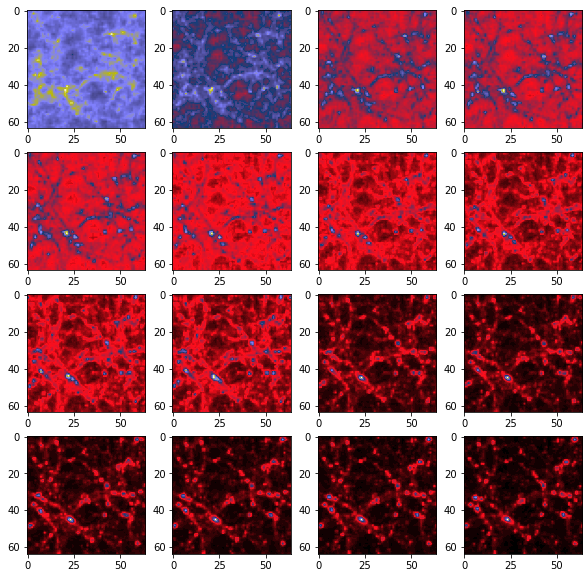

In [7]:
# High res simulation
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0), cmap='gist_stern', vmin=0)

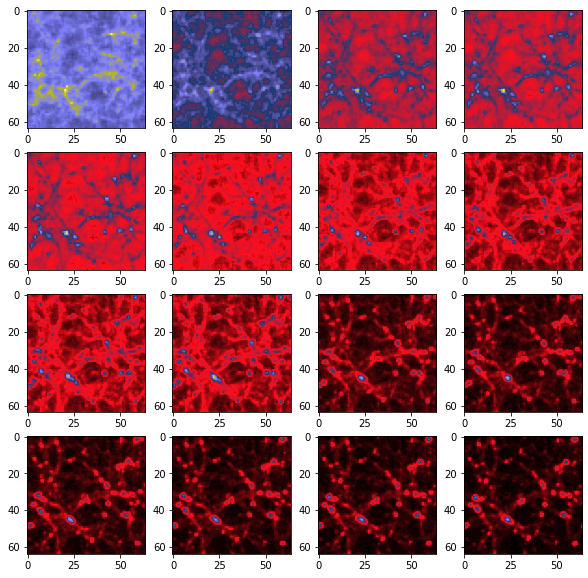

In [8]:
# JaxPM without correction
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), resi[0][::2][i]).sum(axis=0), cmap='gist_stern',
           vmax=cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0).max(),vmin=0)

In [9]:
k, pk_ref = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), poss[-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_i = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), resi[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

/local/home/flanusse/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:488: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


Text(0, 0.5, '$P(k)$')

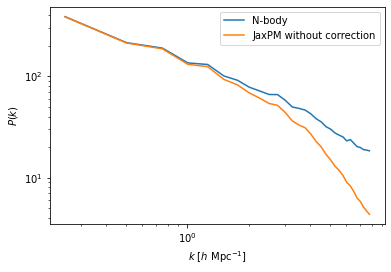

In [10]:
loglog(k,pk_ref, label='N-body')
loglog(k,pk_i, label='JaxPM without correction')
legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")

In [11]:
# Instantiate the neural network
model = hk.without_apply_rng(hk.transform(lambda x,a : NeuralSplineFourierFilter()(x,a)))

params = model.init(next(rng_seq), jnp.zeros([64]), jnp.ones([1]))

In [12]:
def neural_nbody_ode(state, a, cosmo, params):
    """
    state is a tuple (position, velocities)
    """
    pos, vel = state
    
    kvec = fftk(mesh_shape)

    delta = cic_paint(jnp.zeros(mesh_shape), pos)
    
    delta_k = jnp.fft.rfftn(delta)
    
    # Computes gravitational potential
    pot_k = delta_k * laplace_kernel(kvec) * longrange_kernel(kvec, r_split=0)
    
    # Apply a correction filter
    kk = jnp.sqrt(sum((ki/pi)**2 for ki in kvec))
    pot_k = pot_k *(1. + model.apply(params, kk, jnp.atleast_1d(a)))
    
    # Computes gravitational forces
    forces = jnp.stack([cic_read(jnp.fft.irfftn(gradient_kernel(kvec, i)*pot_k), pos) 
                      for i in range(3)],axis=-1)
    
    forces = forces * 1.5 * cosmo.Omega_m

    # Computes the update of position (drift)
    dpos = 1. / (a**3 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * vel
    
    # Computes the update of velocity (kick)
    dvel = 1. / (a**2 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * forces
    
    return dpos, dvel

In [13]:
ref_pos = jnp.stack(poss, axis=0)
ref_vel = jnp.stack(vels, axis=0)

@jax.jit
def loss_fn(params):
  res = odeint(neural_nbody_ode, [poss[0], vels[0]], jnp.array(scales), cosmo, params, rtol=1e-5, atol=1e-5) 
  distance = jnp.sum((res[0] - ref_pos)**2, axis=-1)
  w = jnp.where(distance < 100, distance, 0.)
  # Optional lines to include velocity in the loss
  vel = jnp.sum((res[1] - ref_vel)**2, axis=-1)
  wv = jnp.where(distance < 100, vel, 0.)
  return 0.01*jnp.mean(wv) + jnp.mean(w)

@jax.jit
def update(params, opt_state):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return loss, new_params, new_opt_state

In [14]:
losses = []

In [15]:
import optax
learning_rate=0.01
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

In [52]:
for step in tqdm(range(10000)):
  l, params, opt_state = update(params, opt_state)
  losses.append(l)

  3%|▎         | 272/10000 [29:01<17:17:52,  6.40s/it]


KeyboardInterrupt: 

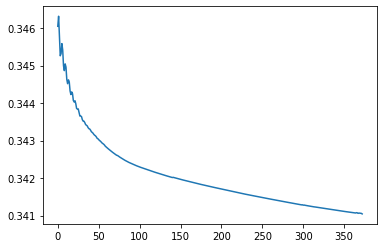

In [53]:
plot(losses[40:])

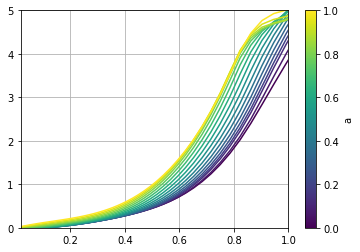

In [68]:
col = cm.viridis(np.linspace(0.,1.0,len(scales[::2])))   

kvals = jnp.logspace(-2.,0,100)*sqrt(3)

for i, a in enumerate(scales[::2]): 
    plot(kvals, model.apply(params, kvals , jnp.atleast_1d(a)), color=col[i])

sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0., vmax=1))
plt.colorbar(sm, label='a')

xlim(kvals[0], 1)
ylim(0,5)
grid()

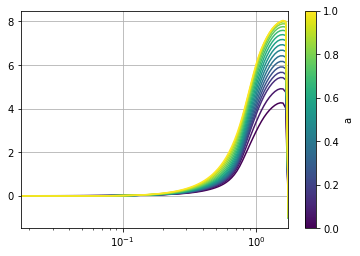

In [36]:
col = cm.viridis(np.linspace(0.,1.0,len(scales[::2])))   

kvals = jnp.logspace(-2.,0,100)*sqrt(3)

for i, a in enumerate(scales[::2]): 
    semilogx(kvals, model.apply(params, kvals , jnp.atleast_1d(a)), color=col[i])

sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0., vmax=1))
plt.colorbar(sm, label='a')

xlim(kvals[0], sqrt(3))
grid()

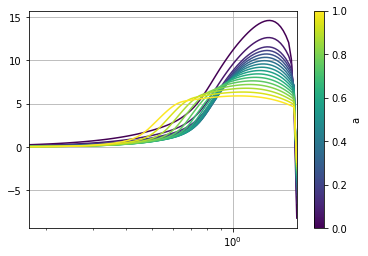

In [134]:
col = cm.viridis(np.linspace(0.,1.0,len(scales[::2])))   

kvals = jnp.logspace(-1.,0,100)*sqrt(3)

for i, a in enumerate(scales[::2]): 
    semilogx(kvals, model.apply(params, kvals , jnp.atleast_1d(a))/a, color=col[i])

sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0., vmax=1))
plt.colorbar(sm, label='a')
xlim(kvals[0], sqrt(3))
grid()

In [55]:
res = odeint(neural_nbody_ode, [poss[0], vels[0]], jnp.array(scales), cosmo, params, rtol=1e-5, atol=1e-5)

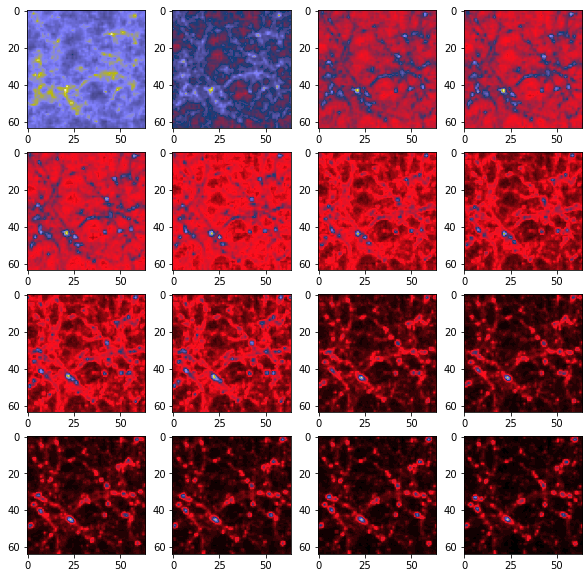

In [56]:
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), res[0][::2][i]).sum(axis=0), cmap='gist_stern',
           vmax=cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0).max(),vmin=0)

In [72]:
k, pk_ref = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), poss[-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_i = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), resi[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_c = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), res[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

/local/home/flanusse/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:488: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


Text(0, 0.5, '$P(k)$')

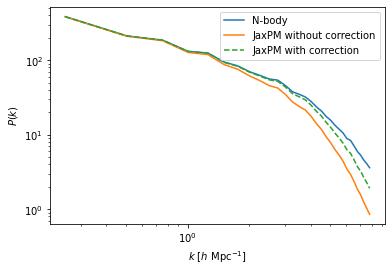

In [73]:
loglog(k, pk_ref, label='N-body')
loglog(k, pk_i, label='JaxPM without correction')
loglog(k, pk_c, '--', label='JaxPM with correction')
legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")

/local/home/flanusse/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:488: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/local/home/flanusse/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:488: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/local/home/flanusse/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:488: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/local/home/flanusse/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:488: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/local/home/flanusse/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:488: ComplexWarning: Casting

(0.0, 1.5)

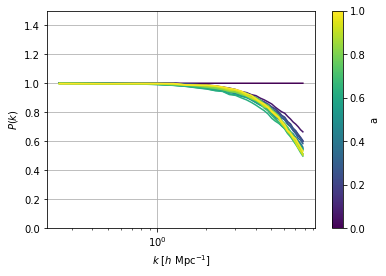

In [69]:
for i, a in enumerate(scales[::2]): 
    k, pk_ref = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), poss[::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    k, pk_c = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), res[0][::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    semilogx(k, pk_c/pk_ref, color=col[i])
    
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")
plt.colorbar(sm, label='a')
plt.grid(True)
plt.ylim(0.,1.5)

/local/home/flanusse/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:488: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/local/home/flanusse/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:488: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/local/home/flanusse/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:488: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/local/home/flanusse/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:488: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/local/home/flanusse/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:488: ComplexWarning: Casting

(0.0, 1.5)

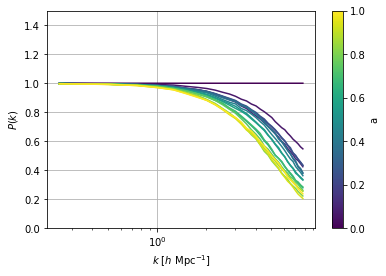

In [70]:
for i, a in enumerate(scales[::2]): 
    k, pk_ref = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), poss[::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    k, pk_i = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), resi[0][::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    semilogx(k, pk_i/pk_ref, color=col[i])
    
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")
plt.colorbar(sm, label='a')
plt.grid(True)
plt.ylim(0.,1.5)

In [71]:
import pickle
pickle.dump( params, open( "camels_25_64_pos_vel.params", "wb" ) )